# Book Preference Learning Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from multitask_personalization.envs.pybullet.pybullet_env import PyBulletEnv
from multitask_personalization.envs.pybullet.pybullet_scene_spec import PyBulletSceneSpec, HiddenSceneSpec
from multitask_personalization.rom.models import SphericalROMModel
from multitask_personalization.envs.pybullet.pybullet_human import HumanSpec
from multitask_personalization.envs.pybullet.pybullet_utils import user_would_enjoy_book
from multitask_personalization.envs.pybullet.pybullet_missions import _explain_user_book_preference
from multitask_personalization.envs.pybullet.pybullet_csp import _get_book_preferences_from_history
from tomsutils.llm import OpenAILLM

pybullet build time: Apr 27 2024 09:33:34
/Users/tom/multitask-personalization/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
human_spec = HumanSpec()
rom_model = SphericalROMModel(human_spec)
hidden_book_preferences = "I only like books that take place in outer space."
hidden_spec = HiddenSceneSpec("handover-only", hidden_book_preferences, rom_model, surfaces_robot_can_clean=[])
llm = OpenAILLM("gpt-4o-mini", Path("../llm_cache"), max_tokens=700)
num_books = 9
scene_spec = PyBulletSceneSpec(num_books=num_books, use_standard_books=True)
env = PyBulletEnv(scene_spec, llm, hidden_spec)

# Generate book descriptions.
book_descriptions = env._generate_book_descriptions(num_books, seed=0)
print("Book descriptions:")
for i, desc in enumerate(book_descriptions):
    print(f"Book {i}: {desc}")

Book descriptions:
Book 0: Title: Cosmos. Author: Carl Sagan.
Book 1: Title: The Diary of Anne Frank. Author: Anne Frank.
Book 2: Title: Moby Dick. Author: Herman Melville.
Book 3: Title: The Hitchhiker's Guide to the Galaxy. Author: Douglas Adams.
Book 4: Title: The Lord of the Rings. Author: J. R. R. Tolkien.
Book 5: Title: And Then There Were None. Author: Agatha Christie.
Book 6: Title: To Kill a Mockingbird. Author: Harper Lee.
Book 7: Title: The Great Gatsby. Author: F. Scott Fitzgerald.
Book 8: Title: 1984. Author: George Orwell.


In [3]:
# Generate the ground-truth preferences for each book.
gt_preferences: dict[str, bool] = {}
for book in book_descriptions:
    gt_preferences[book] = user_would_enjoy_book(book, hidden_book_preferences, llm)
print("Ground-truth preferences:")
for book, preference in gt_preferences.items():
    print(f"Book: {book}, Preference: {preference}")

Ground-truth preferences:
Book: Title: Cosmos. Author: Carl Sagan., Preference: True
Book: Title: The Diary of Anne Frank. Author: Anne Frank., Preference: False
Book: Title: Moby Dick. Author: Herman Melville., Preference: False
Book: Title: The Hitchhiker's Guide to the Galaxy. Author: Douglas Adams., Preference: True
Book: Title: The Lord of the Rings. Author: J. R. R. Tolkien., Preference: False
Book: Title: And Then There Were None. Author: Agatha Christie., Preference: False
Book: Title: To Kill a Mockingbird. Author: Harper Lee., Preference: False
Book: Title: The Great Gatsby. Author: F. Scott Fitzgerald., Preference: False
Book: Title: 1984. Author: George Orwell., Preference: False


In [4]:
def get_book_preferences_from_summary(current_preferences: str, llm: OpenAILLM):
    preferences: dict[str, bool] = {}
    for book in book_descriptions:
        preferences[book] = user_would_enjoy_book(book, current_preferences, llm)
    return preferences


def get_book_preference_accuracy(learned_preferences: dict[str, bool], gt_preferences: dict[str, bool]):
    correct = 0
    for book in learned_preferences:
        if learned_preferences[book] == gt_preferences[book]:
            correct += 1
    return correct / len(learned_preferences)


def get_user_feedback(book, user_preferences, llm):
    enjoyed = gt_preferences[book]
    explanation = _explain_user_book_preference(book, user_preferences, llm, enjoyed=enjoyed)
    new_feedback = f'When I gave the user the book: "{book}", they said: "{explanation}"'
    return new_feedback


def update_preferences(all_user_feedback, llm):
    return _get_book_preferences_from_history(all_user_feedback, llm, seed=0)


def run_single_trial(rng, llm):
    book_order = sorted(book_descriptions)
    rng.shuffle(book_order)
    current_preferences = "Unknown"
    learned_preferences = get_book_preferences_from_summary(current_preferences, llm)
    accuracy = get_book_preference_accuracy(learned_preferences, gt_preferences)
    accuracies = [accuracy]
    all_user_feedback = []
    for book in book_order:
        print("Showing book:", book)
        user_feedback = get_user_feedback(book, hidden_book_preferences, llm)
        print("Got user feedback:", user_feedback)
        all_user_feedback.append(user_feedback)
        current_preferences = update_preferences(all_user_feedback, llm)
        print("Updated preferences:", current_preferences)
        learned_preferences = get_book_preferences_from_summary(current_preferences, llm)
        print("Book preferences:")
        for book, preference in learned_preferences.items():
            print(f"    Book: {book}, Preference: {preference}")
        accuracy = get_book_preference_accuracy(learned_preferences, gt_preferences)
        print("Current accuracy:", accuracy)
        accuracies.append(accuracy)
    return accuracies

rng = np.random.default_rng(0)
num_trials = 1
all_accuracies = []
for _ in range(num_trials):
    accuracies = run_single_trial(rng, llm)
    all_accuracies.append(accuracies)
mean_accuracies = np.mean(all_accuracies, axis=0)

Showing book: Title: The Diary of Anne Frank. Author: Anne Frank.
Got user feedback: When I gave the user the book: "Title: The Diary of Anne Frank. Author: Anne Frank.", they said: "Thanks, but I don't like this book."
Updated preferences: I know that the user likes the following books: <none> and they do not like the following books: The Diary of Anne Frank. Based on this, here are some possible summaries of their preferences:  
1. The user may prefer books with different themes or genres than historical or biographical texts.  
2. The user might be looking for more contemporary or fiction literature as opposed to classic or historical narratives.  
3. The user could favor books that offer lighter subjects or entertainment rather than serious or somber topics.
Book preferences:
    Book: Title: Cosmos. Author: Carl Sagan., Preference: True
    Book: Title: The Diary of Anne Frank. Author: Anne Frank., Preference: False
    Book: Title: Moby Dick. Author: Herman Melville., Preference:

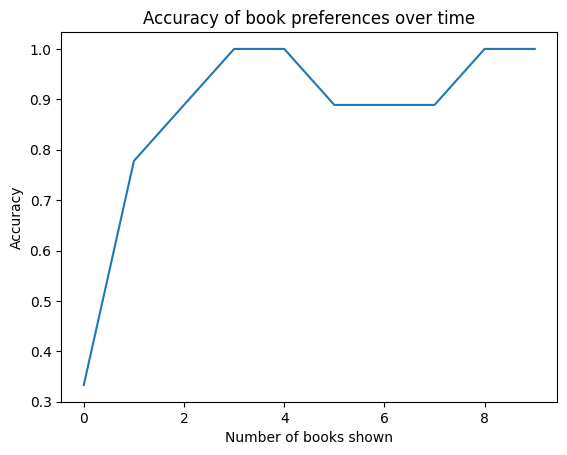

In [5]:
plt.plot(mean_accuracies)
plt.xlabel("Number of books shown")
plt.ylabel("Accuracy")
plt.title("Accuracy of book preferences over time")
plt.show()